Deutsch_Jozsa algorithm is a quantum algorithm that decides if a function is constant or balanced. The circuit indicates an oracle that promises to evaluate a function that can only be constant or balanced.

A function $( f : \mathbb{B}^n \to \mathbb{B} $) is called:
​
- **constant** if $( |f(\mathbb{B}^n)| = 1 $),
- **balanced** if $( |f^{-1}(0)| = |f^{-1}(1)| $).
​

The circuit that evaluates the Deutsch-Jozsa algorithm is presented below:

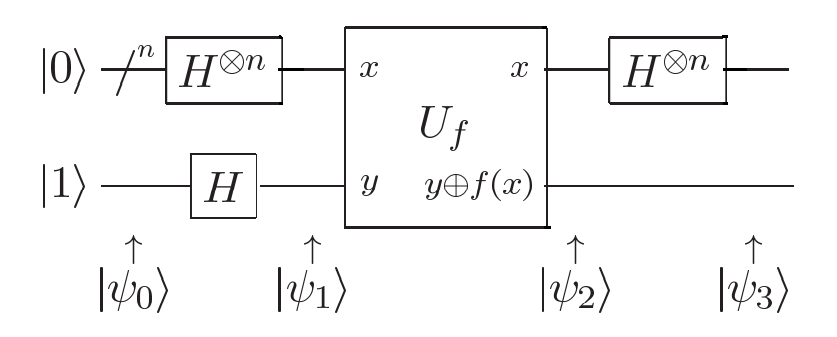

The initial input of the circuit is:  
$| \psi_0 \rangle= |0...0\rangle|1\rangle$  

After the unitary $H^{\otimes n+1}$ is applied to the state, the new state $|\psi_1\rangle$ becomes:  
$
|\psi_1\rangle = \sum_{x \in \{0,1\}^n} \frac{|x\rangle}{\sqrt{2^n}} 
\left[ \frac{|0\rangle - |1\rangle}{\sqrt{2}} \right]
$


The unitary $U_f$, which is the oracle of the circuit, is defined by:  
$U_f|x\rangle|y\rangle=|x\rangle|y\oplus f(x)\rangle$ 

When the unitary $U_f$ is applied to the state $|\psi_1\rangle$, the new state $|\psi_2\rangle$ is:  
$|\psi_2\rangle=\sum_{x}\frac{(-1)^{f(x)}|x\rangle}{\sqrt{2^n}}\left[\frac{|0\rangle-|1\rangle}{\sqrt{2}}\right]$

When the unitary $H^{\otimes n}$ is applied to the state $|x_1,x_2,...,x_n\rangle$, the outcome is:  
$
H^{\otimes n} |x_1, \dots, x_n\rangle = 
\sum_{z_1, \dots, z_n} \frac{(-1)^{x_1 z_1 + \dots + x_n z_n}}{\sqrt{2^n}} |z_1, \dots, z_n\rangle
$

If we define the bit strings $x$ and $z$ as $x=x_1 \dots x_n$ and $z=z_1 \dots z_n$ the equation above can be summarized as:  
$
H^{\otimes n} |x\rangle = 
\sum_{z} \frac{(-1)^{x \cdot z}}{\sqrt{2^n}} |z\rangle
$  

Therefore, when the unitary $H^{\otimes n}\otimes I$ is applied to the state $|\psi_2\rangle$, the new state $|\psi_3\rangle$ is:  
$
|\psi_3\rangle = \sum_{z} \sum_{x} \frac{(-1)^{x \cdot z + f(x)}}{2^n} |z\rangle 
\left[ \frac{|0\rangle - |1\rangle}{\sqrt{2}} \right]
$


Note that, the amplitude of the state $|0\rangle^n$ is $\sum_x\frac{(-1)^{f(x)}}{2^n}$. If the function $f$ is constant, the amplitude equals either $1$ or $-1$, which means if the first $n$ qubits are measured, it is guaranteed that the outcome is $|0\rangle^n$, If the function $f$ is balanced, the sum yields to zero since there is an equal number of the positive and negative contributions cancel. What this means is the function $f$ is constant, the state $|0\rangle^n$ must be measured, and if it is balanced, all the possible states except $|0\rangle^n$ must be measured at the first $n$ queries.

Here is the  description of the code:

Importing the useful libraries:

In [ ]:

import argparse
import re
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from ccz_7T_decomposition import *
from dj_circuit import *

# suppress qiskit 1.0 deprecation warnings:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Example code that raises warnings
warnings.warn("This is a warning!")


Creating a constant oracle:

In [ ]:
def create_constant_oracle(n_qubits, output):
    """
    Creates a 'constant' oracle.

    If `output` is 0, the oracle always returns 0.
    If `output` is 1, the oracle always returns 1.

    Args:
        n_qubits (int): The number of input qubits.
        output (int): The constant output value of the function (0 or 1).

    Returns:
        QuantumCircuit: A quantum circuit implementing the constant oracle.
    """
    oracle = QuantumCircuit(n_qubits + 1)

    # If the oracle should always output 1, we flip the "output" qubit
    # using an X-gate (think of it as a NOT gate on a qubit).
    if output == 1:
        oracle.x(n_qubits)

    return oracle

There is multiple ways to create a constant function. For example, using just a Toffoli gate creates a balanced function:  
| input | output | 
|----------|----------|
| 0 0 0   | 0   |
| 1 0 1 | 1   | 
| 0 1 0   | 0   |
| 0 0 1   | 0   |
| 1 1 0 | 1   | 
| 0 1 1   | 1   |
| 1 0 1   | 1   |
| 1 1 1 | 0   |


Since the Toffoli transform is defined as:  
$(x,y,z)\mapsto x\cdot y \oplus z $

When we have two balanced functions for the different registers $f_1(x_1)$ and $f_2(x_2)$, the function $g(x_1,x_2)=f_1(x_1)\oplus f_2(x_2)$ will be balanced. Therefore, if we have two Toffoli gates on different registers and if we apply a `CNOT` gate where the control qubits are the last wires of the Toffoli gates and the target qubit is a wire that is fixed to the state $|1\rangle$, we will get the sum of two balanced functions plus the $|1\rangle$ state which is a desired balanced oracle for the Deutsch-Jozsa circuit. We can add as many Toffoli gates as we want with this method iteratively. 

In [ ]:
def create_balanced_oracle(toff_count):
    """
    Creates a 'balanced' oracle.

    Half of the input bit patterns output 0, and the other half output 1.

    For demonstration, this function implements a simple balanced function
    by placing X-gates on the first qubit of the input as a control,
    inverting the output qubit for half of the inputs.

    Args:
        n_qubits (int): The number of input qubits.

    Returns:
        QuantumCircuit: A quantum circuit implementing the balanced oracle.
    """
    n_qubits=3*toff_count+1
    oracle=QuantumCircuit(n_qubits)
    for i in range(0,n_qubits-1,3):
        oracle.ccx(i, i+1, i+2)
        oracle.cx(i+2, n_qubits-1)
        
    return oracle
        
print(create_balanced(3))

The circuit for the Deutsch-Jozsa algorithm is implemented below:

In [ ]:
def deutsch_jozsa_circuit(oracle, n_qubits):
    """
    Assembles the full Deutsch-Jozsa quantum circuit.

    The circuit performs the following steps:
    1. Start all 'input' qubits in |0>.
    2. Start the 'output' qubit in |1>.
    3. Apply Hadamard gates to all qubits.
    4. Apply the oracle.
    5. Apply Hadamard gates again to the input qubits.
    6. Measure the input qubits.

    Args:
        oracle (QuantumCircuit): The circuit encoding the 'mystery' function f(x).
        n_qubits (int): The number of input qubits.

    Returns:
        QuantumCircuit: The complete Deutsch-Jozsa circuit ready to run.
    """
    # Total of n_qubits for input, plus 1 for the output qubit
    dj_circuit = QuantumCircuit(n_qubits + 1, n_qubits)

    # 1. The input qubits are already set to |0>.
    # 2. The output qubit is set to |1>. We achieve this by an X gate.
    dj_circuit.h(n_qubits)
    dj_circuit.s(n_qubits)
    dj_circuit.s(n_qubits)
    dj_circuit.h(n_qubits)

    # 3. Apply Hadamard gates to all qubits (input + output).
    for qubit in range(n_qubits + 1):
        dj_circuit.h(qubit)

    # 4. Append the oracle circuit.
    dj_circuit.compose(oracle, inplace=True)

    # 5. Apply Hadamard gates again to the input qubits ONLY.
    for qubit in range(n_qubits):
        dj_circuit.h(qubit)

    # 6. Finally, measure the input qubits.
    for qubit in range(n_qubits):
        dj_circuit.measure(qubit, qubit)

    return dj_circuit

Running the algorithm:

In [ ]:
def run_deutsch_jozsa_test(n_qubits, oracle_type='constant', constant_output=0):
    """
    Builds and runs the Deutsch-Jozsa circuit for either a constant oracle
    or a balanced oracle, then prints the results.

    Args:
        n_qubits (int): Number of input qubits.
        oracle_type (str): Specifies the type of oracle, either 'constant' or 'balanced'.
        constant_output (int): If the oracle is constant, determines whether it returns 0 or 1.
    """
    # Create the chosen oracle
    if oracle_type == 'constant':
        oracle = create_constant_oracle(n_qubits, constant_output)
        print(f"Using a CONSTANT oracle that always returns {constant_output}")
    else:
        oracle = create_balanced_oracle(toff_count)
        print("Using a BALANCED oracle.")

    # Create the Deutsch-Jozsa circuit
    dj_circ = deutsch_jozsa_circuit(oracle, n_qubits)

    print(f"Quantum Circuit:\n")
    print(dj_circ,"\n")
    
    # Simulate the circuit after decomposition
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(dj_circ, simulator, shots=4096)
    result = job.result()
    counts = result.get_counts()

    # Interpret the measurement
    # If all measured bits are 0 (e.g., '000' for 3 qubits), then the
    # function is constant. Otherwise, it is balanced.
    measured_result = max(counts, key=counts.get)  # The most likely outcome
    if measured_result == '0' * n_qubits:
        print("Conclusion: f(x) is CONSTANT.")
    else:
        print("Conclusion: f(x) is BALANCED.")
    
    return dj_circ


def main():
    import os
    import sys

    # Add the parent directory to sys.path
    sys.path.append(os.path.abspath(os.path.join(os.path.dirname('circuits/dj_circuit.py'), '..')))
    
    import qcm_sim as sim
    from circuits import toff_7T_decomposition as toff

    parser = argparse.ArgumentParser(description="Run T Circuit.")
    
    # Optional argument to save QASM
    parser.add_argument(
        "-b", "--save_qasm", action="store_true", help="Save T QASM"
    )

    args = parser.parse_args()

    n = 10

    print(f"Number of qubits: {n}\n")

    
    print(f"Quantum Circuit:\n")

    """
    # Test deutsch jozsa on constant:
    qc = run_deutsch_jozsa_test(n_qubits=n, oracle_type='constant', constant_output=0)

    print(qc,"\n")

    # Simulate the circuit after decomposition
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=4096)
    result = job.result()
    counts = result.get_counts()

    print("Qiskit Simulation Results:")
    #print(counts)
    percentages = [(k, v / sum(counts.values()))
                        for k, v in counts.items()]
    print(f"Percentages: {percentages}\n")

    # Apply the 7T decomposition if applicable
    qc_with_decomposition = toff.apply_toff_via_7t_decomposition(qc)

    qasm_code = qc_with_decomposition.qasm()

    # Replace 'tdg' with 's; s; s; t;'
    modified_qasm_code = re.sub(r'\btdg\b', 's;\ns;\ns;\nt;', qasm_code)

    with open(f"./qasm_files/dj_10.qasm", "w") as f:
        f.write(modified_qasm_code)


    print("CNC Tableau Simulation Results:")

    # Specify the directory where the QASM file is located.
    file_directory = "./qasm_files/"
    filename = "dj_10"
    qasm_file = filename + ".qasm"
    clifford_filename = filename + "_msi.qasm"

    # Run the gadgetized circuit simulation.
    counts, outputs, born_rule_estimates, shot_times = sim.run_qcm(file_directory, qasm_file, clifford_filename, shots=4096)
    """


    print(f"Quantum Circuit:\n")

    # Test deutsch jozsa on constant:
    qc = run_deutsch_jozsa_test(n_qubits=n, oracle_type='balanced', constant_output=0)

    print(qc,"\n")

    # Simulate the circuit after decomposition
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=4096)
    result = job.result()
    counts = result.get_counts()

    print("Qiskit Simulation Results:")
    #print(counts)
    percentages = [(k, v / sum(counts.values()))
                        for k, v in counts.items()]
    print(f"Percentages: {percentages}\n")

    # Apply the 7T decomposition if applicable
    qc_with_decomposition = toff.apply_toff_via_7t_decomposition(qc)

    print("With decomposition:")
    print(qc_with_decomposition)

    qasm_code = qc_with_decomposition.qasm()

    #print(qasm_code)

    # Replace 'tdg' with 's; s; s; t;'
    modified_qasm_code = re.sub(r'\btdg\b', 's;\ns;\ns;\nt;', qasm_code)

    with open(f"./qasm_files/dj_10.qasm", "w") as f:
        f.write(modified_qasm_code)


    print("CNC Tableau Simulation Results:")

    # Specify the directory where the QASM file is located.
    file_directory = "./qasm_files/"
    filename = "dj_10"
    qasm_file = filename + ".qasm"
    clifford_filename = filename + "_msi.qasm"

    # Run the gadgetized circuit simulation.
    counts, outputs, born_rule_estimates, shot_times = sim.run_qcm(file_directory, qasm_file, clifford_filename, shots=4096)


if __name__ == "__main__":
    main()
